In [1]:
import sys; sys.path.append('../')
import yaml
import datetime
import pickle

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import torch
import torchmetrics
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import utils

In [2]:
device = 'cuda'
batch_size = 1024

In [3]:
def get_writer(name:str):
    log_dir = f"logs/fit/prematch/{name}"
    writer = SummaryWriter(log_dir, comment=datetime.datetime.now().strftime("%Y.%m.%d - %H:%M"))
    return writer

In [5]:
train_df = pd.read_json(f'../parse/output/league/train_df.json')
val_df = pd.read_json(f'../parse/output/league/val_df.json')
test_df = pd.read_json(f'../parse/output/league/test_df.json')

train_df['part'] = 'train'
val_df['part'] = 'val'
test_df['part'] = 'test'

corpus = train_df.reset_index()
train_dataset = utils.nn.datasets.LeagueDataset(
    corpus=corpus, 
    indeces=corpus.index[(corpus['part'] == 'train')], 
    y_output='binary',
).build()

corpus = pd.concat([train_df, val_df]).reset_index()
val_dataset = utils.nn.datasets.LeagueDataset(
    corpus=corpus, 
    indeces=corpus.index[(corpus['part'] == 'val')], 
    y_output='binary',
).build()

corpus = pd.concat([train_df, val_df, test_df]).reset_index()
test_dataset = utils.nn.datasets.LeagueDataset(
    corpus=corpus, 
    indeces=corpus.index[(corpus['part'] == 'test')], 
    y_output='binary',
).build()


with open('output/train_cache.pkl', 'wb') as p:
    pickle.dump(train_dataset.cache, p)
    
with open('output/val_cache.pkl', 'wb') as p:
    pickle.dump(val_dataset.cache, p)
    
with open('output/test_cache.pkl', 'wb') as p:
    pickle.dump(test_dataset.cache, p)

In [6]:
train_dataset = utils.nn.datasets.LeagueDataset(
    corpus=None, 
    indeces=None, 
    y_output='binary')
train_dataset.cache = pickle.load(open('output/train_cache.pkl', 'rb'))
train_dataset.build()


val_dataset = utils.nn.datasets.LeagueDataset(
    corpus=None, 
    indeces=None, 
    y_output='binary')
val_dataset.cache = pickle.load(open('output/val_cache.pkl', 'rb'))
val_dataset.build()


test_dataset = utils.nn.datasets.LeagueDataset(
    corpus=None, 
    indeces=None, 
    y_output='binary')
test_dataset.cache = pickle.load(open('output/test_cache.pkl', 'rb'))
test_dataset.build()

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import torchsummary

from utils.nn import blocks
from utils.base import ConfigBase


class PrematchModel(ConfigBase, nn.Module):
    def __init__(self, teams_num, team_emb_dim=8, embed_dim=64, num_heads=4, num_encoder_layers=6, dropout=0.25):
        super().__init__()
        self.features_config = self.get_config('features')
        self.models_config = self.get_config('models')

        if self.features_config['league']['features']['tabular']['teams']:
            self.team_embedding = nn.Embedding(teams_num+1, team_emb_dim)

        self.windowedGamesFeatureEncoder = blocks.WindowedGamesFeatureEncoder(embed_dim, dropout)
        self.transformer = nn.ModuleList(
            [
                blocks.TransformerEncoder(
                    embed_dim=embed_dim, 
                    num_heads=num_heads, 
                    ff_dim=embed_dim, 
                    dropout=dropout,
                ) for _ in range(num_encoder_layers)
            ]
        )

        compare_fnn_embed_dim = embed_dim
        if self.features_config['league']['features']['tabular']['teams']:
            compare_fnn_embed_dim += team_emb_dim

        self.compare_fnn = nn.Sequential(
            nn.Linear(compare_fnn_embed_dim,    compare_fnn_embed_dim//2, bias=False), nn.Tanh(),
            nn.Linear(compare_fnn_embed_dim//2, compare_fnn_embed_dim//2, bias=False), nn.Tanh(),
            nn.Linear(compare_fnn_embed_dim//2, 1, bias=False),
        )
        

    def forward(self, inputs: dict):
        # --------------------------------------------------------- #
        r_window, d_window = self.windowedGamesFeatureEncoder(inputs)

        # --------------------------------------------------------- #
        r_window = self.__forward_through_transformer(
            window=r_window, 
            key_padding_mask=inputs['r_window']['padded_mask'])
        d_window = self.__forward_through_transformer(
            window=d_window, 
            key_padding_mask=inputs['d_window']['padded_mask'])

        # --------------------------------------------------------- #
        # pooled_r = torch.mean(r_window, dim=1)
        # pooled_d = torch.mean(d_window, dim=1)
        pooled_r = self.__global_avg_pooling(
            window=r_window,
            seq_len=inputs['r_window']['seq_len'],
            key_padding_mask=inputs['r_window']['padded_mask'])
        pooled_d = self.__global_avg_pooling(
            window=r_window,
            seq_len=inputs['d_window']['seq_len'],
            key_padding_mask=inputs['d_window']['padded_mask'])  
        
        # --------------------------------------------------------- #
        if self.features_config['league']['features']['tabular']['teams']:
            team_r = self.team_embedding(inputs['teams']['radiant'])
            pooled_r = torch.cat([pooled_r, team_r], dim=-1)

            team_d = self.team_embedding(inputs['teams']['dire'])
            pooled_d = torch.cat([pooled_d, team_d], dim=-1)
        
        # --------------------------------------------------------- #
        compare = self.compare_fnn(pooled_r - pooled_d)

        return compare


    def __forward_through_transformer(self, window: torch.Tensor, key_padding_mask: torch.Tensor=None) -> torch.FloatTensor:
        for layer in self.transformer:
            window = layer(window, key_padding_mask=~key_padding_mask)

        return window


    def __global_avg_pooling(self, window: torch.Tensor, seq_len: torch.Tensor, key_padding_mask: torch.Tensor)  -> torch.FloatTensor:
        # multiply window by mask - zeros all padded tokens
        pooled = torch.mul(window, key_padding_mask.unsqueeze(2))
        # |pooled| : (batch_size, seq_len, d_model)

        # sum all elements by seq_len dim
        pooled = pooled.sum(dim=1)
        # |pooled| : (batch_size, d_model)

        # divide samples by by its seq_len, so we will get mean values by each sample
        pooled = pooled / seq_len.unsqueeze(1)
        # |pooled| : (batch_size, d_model)

        return pooled
        

    def configure_optimizers(self):
        raise NotImplementedError("This is for torch lightning")
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer


    def training_step(self, train_batch: dict, batch_idx: int):
        raise NotImplementedError("This is for torch lightning")
        out = self.forward(train_batch)    
        loss = F.binary_cross_entropy_with_logits(out, train_batch['y'])
        return loss

    def summary(self):
        torchsummary.summary(self)

In [39]:
name = f'test try {datetime.datetime.now().strftime("%Y.%m.%d - %H-%M")}'

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

model = PrematchModel(
    teams_num=train_df[['r_team_id', 'd_team_id']].max().max(),
    team_emb_dim=4, 
    embed_dim=64,
    num_encoder_layers=4,
    num_heads=2,
    dropout=0.2,
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = utils.nn.shedulers.TransformerLRScheduler(
    optimizer=optimizer,
    init_lr=1e-6,
    peak_lr=5e-4,
    final_lr=1e-5,
    final_lr_scale=0.05,
    warmup_steps=6,
    decay_steps=16,
)

trainer = utils.nn.trainers.PremtachTrainer(
    model=model, 
    loss_fn=torch.nn.BCEWithLogitsLoss(), 
    sheduler=None,
    optimizer=optimizer,
    metric=torchmetrics.AUROC(num_classes=1),
    device=device
)

acc = torchmetrics.Accuracy(num_classes=1)
auc = torchmetrics.AUROC(num_classes=1)

writer = get_writer(name)

C:\Users\royta\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [40]:
model.summary()

Layer (type:depth-idx)                                       Param #
├─Embedding: 1-1                                             720
├─WindowedGamesFeatureEncoder: 1-2                           --
|    └─StatsEncoder: 2-1                                     --
|    |    └─Linear: 3-1                                      4,160
|    |    └─Linear: 3-2                                      4,160
|    |    └─ModuleList: 3-3                                  5,440
|    └─ResultEncoder: 2-2                                    --
|    |    └─Embedding: 3-4                                   128
|    └─Embedding: 2-3                                        2,112
├─ModuleList: 1-3                                            --
|    └─TransformerEncoder: 2-4                               --
|    |    └─LayerNorm: 3-5                                   128
|    |    └─LayerNorm: 3-6                                   128
|    |    └─MultiheadAttention: 3-7                          16,640
|    |    └─Pos

In [41]:
try:
    wait = 0
    patience = 50

    epoch = 0
    best_loss = -np.inf
    while wait < patience:
        train_loss = trainer.train_epoch(train_loader)

        val_pred, val_true = trainer.evaluate(val_loader)
        val_pred, val_true = val_pred.sigmoid(), val_true.int()
        metrics = {
            'AUC': auc(val_pred, val_true),
            'ACC': acc(val_pred, val_true),
        }
        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('AUC/train', trainer.metric.compute(), epoch)
        writer.add_scalar('AUC/val', metrics['AUC'], epoch)
        writer.add_scalar('ACC/val', metrics['ACC'], epoch)


        wait+=1
        epoch+=1
        if metrics['AUC'] > best_loss:
            torch.save(trainer.checkpoint(), f'output/models_w/prematch/{name}.torch')
            best_loss = metrics['AUC']
            wait = 0

except KeyboardInterrupt:
    print("KeyboardInterrupt")

In [42]:
test_pred, test_true = trainer.evaluate(test_loader)
test_pred, test_true = test_pred.sigmoid(), test_true.int()

metrics = {
    'AUC': auc(val_pred, val_true),
    'ACC': acc(val_pred, val_true),
}
metrics

{'AUC': tensor(0.6017), 'ACC': tensor(0.5106)}

In [43]:
df = pd.DataFrame({
    'y_pred': test_pred[:, 0],
    'y_true': test_true[:, 0],
})

In [44]:
from sklearn import metrics


class BinaryINF():
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.y_true, self.y_pred = df['y_true'].values, df['y_pred'].values
        
        self.balance = self.y_true.mean()
        self.accuracy = self._accuracy(self.y_true, self.y_pred)
        self.precission = self._precision(self.y_true, self.y_pred)
        self.recall = self._recall(self.y_true, self.y_pred)
        self.confusion_matrix = self._confusion_matrix(self.y_true, self.y_pred)
        self.fpr, self.tpr, self.threshold, self.auc, self.eer = self._roc_auc(self.y_true, self.y_pred)
        
    def _roc_auc(self, y_true, y_pred):
        fpr, tpr, threshold = metrics.roc_curve(y_true,  y_pred)
        
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        eer1, eer2 = fpr[np.nanargmin(np.absolute((fnr - fpr)))], fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = (eer1+eer2)/2
        
        auc = metrics.roc_auc_score(y_true, y_pred)
        return fpr, tpr, threshold, auc, eer
        
        
    def _accuracy(self, y_true, y_pred):
        return 1 - np.abs(np.round(y_pred) - y_true).sum()/len(y_true)
    
    
    def _precision(self, y_true, y_pred):
        """Precision   можно   интерпретировать  как   долю 
        объектов,  названных классификатором положительными 
        и при этом действительно являющимися положительными
        """
        return metrics.precision_score(y_true, np.around(y_pred))
    
    
    def _recall(self, y_true, y_pred):
        """recall показывает, какую долю объектов 
        положительного  класса  из  всех объектов 
        положительного  класса   нашел   алгоритм
        """
        return metrics.recall_score(y_true, np.around(y_pred))
    
    
    def _confusion_matrix(self, y_true, y_pred):
        return metrics.confusion_matrix(y_true, np.around(y_pred))
    
    
    def comparison_curve(self):
        """ df columns: y_true, y_pred, r_odd, d_odd, ID"""
        values = self.df.values

        b_curve = [0]
        m_curve = [0]
        for game in values:
            # Chance to win Radiant/Dire
            b_r, b_d = 1/game[2], 1/game[3]
            m_r, m_d = game[1], 1-game[1]

            if game[0] == 1:
                if b_r > b_d: b_curve.append(b_curve[-1] + b_r)
                else: b_curve.append(b_curve[-1] - b_r)

                if m_r > m_d: m_curve.append(m_curve[-1] + m_r)
                else: m_curve.append(m_curve[-1] - m_r)

            elif game[0] == 0:
                if b_r < b_d: b_curve.append(b_curve[-1] + b_d)
                else: b_curve.append(b_curve[-1] - b_d)

                if m_r < m_d: m_curve.append(m_curve[-1] + m_d)
                else: m_curve.append(m_curve[-1] - m_d)

        return b_curve, m_curve
    
    def against_book_curve(self):
        """ df columns: y_true, y_pred, r_odd, d_odd, ID"""
        values = self.df.values

        bank = [100]
        for game in values:
            # Odds Radiant/Dire
            r_odd, d_odd = game[2], game[3]
            # Chance to win Radiant/Dire
            r_chance, d_chance = game[1], 1-game[1]

            # Place bet on raidnat
            if r_chance >= d_chance:
                # 10% of babk 
                bet = 10 * r_chance
                # Add a profit
                if game[0] == 1: bank.append(bank[-1] + bet*r_odd-bet)
                else: bank.append(bank[-1] - bet)

            elif r_chance < d_chance:
                bet = 10 * d_chance
                if game[0] == 0: bank.append(bank[-1] + bet*d_odd-bet)
                else: bank.append(bank[-1] - bet)
        return bank

In [45]:
inf = BinaryINF(df)

In [46]:
inf.accuracy, inf.auc, inf.precission, inf.recall,

(0.5308641975308642,
 0.5648387096774193,
 0.40540540540540543,
 0.4838709677419355)

In [47]:
test_pred.shape

torch.Size([81, 1])

In [48]:
val_pred.shape

torch.Size([47, 1])

In [49]:
import seaborn as sns

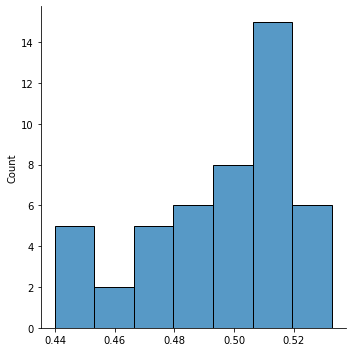

In [50]:
sns.displot(val_pred[:, 0])

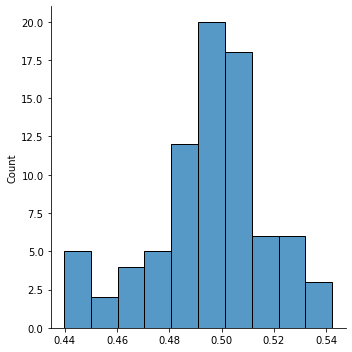

In [51]:
sns.displot(test_pred[:, 0])